In [33]:
import numpy as np
import pandas as pd
import glob
import torch
import pickle
import os
import glob, sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import _rebuild; _rebuild()
%matplotlib inline 
import seaborn as sns
from matplotlib.lines import Line2D

os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append(os.path.join(os.path.abspath(os.getcwd()),".."))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'lines.markeredgewidth': 1})
%matplotlib inline 
import seaborn as sns
from matplotlib.lines import Line2D
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
# sns.set_style('white')

pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
matplotlib.rcParams.update(pgf_with_rc_fonts)


# import FERL Modules
from utils.learned_feature import LearnedFeature
from utils.plot_utils import *
from utils.environment_utils import *

In [4]:
# -- Distance to Table -- #

def table_features(objectID, waypt):
    """
    Computes the total feature value over waypoints based on z-axis distance to table.
    ---
    Params:
        objectID -- environment where the feature lives
        waypt -- single waypoint
    Returns:
        dist -- scalar feature
    """
    if len(waypt) < 11:
        waypt = np.append(np.append(np.array([0]), waypt.reshape(7)), np.array([0,0,0]))
    for jointIndex in range(p.getNumJoints(objectID["robot"])):
        p.resetJointState(objectID["robot"], jointIndex, waypt[jointIndex])
    coords = robot_coords(objectID["robot"])
    EEcoord_z = coords[6][2]
    return EEcoord_z

# -- Distance to Laptop -- #

def laptop_features(objectID, waypt):
    """
    Computes distance from end-effector to laptop in xy coords
    Params:
        objectID -- environment where the feature lives
        waypt -- single waypoint
    Returns:
        dist -- scalar distance where
            0: EE is at more than 0.3 meters away from laptop
            +: EE is closer than 0.3 meters to laptop
    """
    if len(waypt) < 11:
        waypt = np.append(np.append(np.array([0]), waypt.reshape(7)), np.array([0,0,0]))
    for jointIndex in range(p.getNumJoints(objectID["robot"])):
        p.resetJointState(objectID["robot"], jointIndex, waypt[jointIndex])
    coords = robot_coords(objectID["robot"])
    EE_coord_xy = coords[6][0:2]
    posL, _ = p.getBasePositionAndOrientation(objectID["laptop"])
    laptop_xy = posL[0:2]
    dist = np.linalg.norm(EE_coord_xy - laptop_xy) - 0.3
    if dist > 0:
        return 0
    return -dist

# -- Proxemics -- #

def proxemics_features(objectID, waypt):
    """
    Computes distance from end-effector to human proxemics in xy coords
    Params:
        objectID -- environment where the feature lives
        waypt -- single waypoint
    Returns:
        dist -- scalar distance where
            0: EE is at more than 0.3 meters away from human
            +: EE is closer than 0.3 meters to human
    """
    if len(waypt) < 11:
        waypt = np.append(np.append(np.array([0]), waypt.reshape(7)), np.array([0,0,0]))
    for jointIndex in range(p.getNumJoints(objectID["robot"])):
        p.resetJointState(objectID["robot"], jointIndex, waypt[jointIndex])
    coords = robot_coords(objectID["robot"])
    EE_coord_xy = coords[6][0:2]
    posH, _ = p.getBasePositionAndOrientation(objectID["human"])
    human_xy = list(posH[0:2])

    # Modify ellipsis distance.
    EE_coord_xy[1] /= 3
    human_xy[1] /= 3
    dist = np.linalg.norm(EE_coord_xy - human_xy) - 0.3
    if dist > 0:
        return 0
    return -dist

In [5]:
# Setup case variables.
weights = [0.0, 10.0, 10.0]
gt_features = [["coffee", "table", "laptop"],
               ["coffee", "laptop", "table"],
               ["coffee", "table", "proxemics"]]
learned_weights = [np.array([0.0, 4.03901256, 5.51417794]),
                   np.array([0.0, 4.35964768, 4.88110989]),
                   np.array([0.0, 3.09983027, 5.1572305])]
                               
# Setup environment.
resources_dir = parent_dir + "/data/resources/"
physicsClient = p.connect(p.DIRECT)
p.setAdditionalSearchPath(resources_dir)
objectID = setup_environment()
p.setGravity(0, 0, 0)
p.setRealTimeSimulation(1)

In [6]:
# Step 1. Load GT to get test points.
data_file = parent_dir + '/data/gtdata/data_{}.npz'.format("table")
npzfile = np.load(data_file)
train = npzfile['x']

# Step 2. Get feat_range for all 3 features
table_vals = np.array([table_features(objectID, waypt) for waypt in train[:, :7]])
table_vals = (table_vals - min(table_vals)) / (max(table_vals) - min(table_vals))
laptop_vals = np.array([laptop_features(objectID, waypt) for waypt in train[:, :7]])
laptop_vals = (laptop_vals - min(laptop_vals)) / (max(laptop_vals) - min(laptop_vals))
proxemics_vals = np.array([proxemics_features(objectID, waypt) for waypt in train[:, :7]])
proxemics_vals = (proxemics_vals - min(proxemics_vals)) / (max(proxemics_vals) - min(proxemics_vals))
GT_vals = {"table": table_vals, "laptop": laptop_vals, "proxemics": proxemics_vals}

In [7]:
user_MSEs_to_plot = []
expert_MSEs_to_plot = []
for case in range(3):
    # Step 3. Load the unknown feature.
    feat = gt_features[case][-1]
    all_user_feat_files = glob.glob(parent_dir + '/data/user_data/user?_{}_1.pt'.format(feat)) + \
                        glob.glob(parent_dir + '/data/user_data/user??_{}_1.pt'.format(feat))
    list_of_learned_user_features = []
    n_users = len(all_user_feat_files)
    for user_feat_file in all_user_feat_files:
        list_of_learned_user_features.append(torch.load(user_feat_file))
        
    all_expert_feat_files = glob.glob(parent_dir + '/data/expert_data/expert?_{}_1.pt'.format(feat)) + \
                    glob.glob(parent_dir + '/data/expert_data/expert??_{}_1.pt'.format(feat))
    list_of_learned_expert_features = []
    n_experts = len(all_expert_feat_files)
    for expert_feat_file in all_expert_feat_files:
        list_of_learned_expert_features.append(torch.load(expert_feat_file))
        
    # Step 4. Compute GT cost.
    gt_costs = GT_vals[gt_features[case][1]] * weights[1] + GT_vals[gt_features[case][2]] * weights[2]        
    gt_costs = (gt_costs - gt_costs.min())/(gt_costs.max() - gt_costs.min())
    
    # Step 5. Compute cost MSEs.
    user_MSEs = []
    for i in range(n_users):
        learned_vals = list_of_learned_user_features[i].function(train)
        learned_costs = learned_weights[case][2] * learned_vals + learned_weights[case][1] * GT_vals[gt_features[case][1]]
        learned_costs = (learned_costs - learned_costs.min())/(learned_costs.max() - learned_costs.min())
        mse_temp = ((gt_costs - learned_costs)**2).mean()
        user_MSEs.append(mse_temp)
    user_MSEs_to_plot.append(user_MSEs)
    
    expert_MSEs = []
    for i in range(n_experts):
        learned_vals = list_of_learned_expert_features[i].function(train)
        learned_costs = learned_weights[case][2] * learned_vals + learned_weights[case][1] * GT_vals[gt_features[case][1]]
        learned_costs = (learned_costs - learned_costs.min())/(learned_costs.max() - learned_costs.min())
        mse_temp = ((gt_costs - learned_costs)**2).mean()
        expert_MSEs.append(mse_temp)
    expert_MSEs_to_plot.append(expert_MSEs)

In [8]:
print([np.mean(x) for x in user_MSEs_to_plot])
print([np.std(x) for x in user_MSEs_to_plot])

[0.023475944692333408, 0.045705939426235805, 0.0441683681615381]
[0.004218688348179211, 0.006137525587113812, 0.0026794456112418236]


In [9]:
user_MSEs_to_plot

[[0.01666151011633845,
  0.01867418719154754,
  0.025444647441632787,
  0.019321421380791216,
  0.02255816008942537,
  0.022075931159100882,
  0.030496078985243487,
  0.027290614822277705,
  0.02076415510413108,
  0.027940089309848377,
  0.02861719002825264,
  0.021867350679411313],
 [0.04395545564762609,
  0.039818655285811286,
  0.04536258845593131,
  0.03701070289809404,
  0.061194106091872216,
  0.04536761274247013,
  0.04217895591752224,
  0.046546960370930535,
  0.04708249844899971,
  0.04299509307477142,
  0.042965262704815994,
  0.053993381475984745],
 [0.04003364129631675,
  0.04448046504917142,
  0.04327835637304105,
  0.046485704050163106,
  0.04771123227844384,
  0.041526665467367656,
  0.042276373350395836,
  0.049987912768984524,
  0.04472457744048009,
  0.0442764247358107,
  0.04202726716663603,
  0.04321179796164626]]

In [10]:
def get_MSEs(df):
    # create vector of all n_trajs
    if "config/n_train_trajs" in df:
        key = "config/n_train_trajs"
    else:
        key = "n_traj"
    list_n_traj = df[key].unique()
    
    # create a list of delta_dist arrays
    MSEs = []
    for i in list_n_traj:
        temp = [experiment for experiment in df[df[key] == i]['delta_dist']]
        MSE = [np.mean(x**2) for x in temp]
        MSEs.append(MSE)
    return MSEs

In [11]:
MEIRLfiles = ["MEIRLcost_tablelaptop_case1.p", "MEIRLcost_tablelaptop_case2.p", "MEIRLcost_tableproxemics_case3.p"]
MEIRLdfs = []
for i in range(len(MEIRLfiles)):
    MEIRLfile = parent_dir + "/data/costs/" + MEIRLfiles[i]
    with open(MEIRLfile, 'rb') as m:
        MEIRLdfs.append(pickle.load(m,encoding="latin1"))

MEIRLMSEs = []
for case in range(len(MEIRLfiles)):
    MEIRLMSEs.append(get_MSEs(MEIRLdfs[case])[-1])

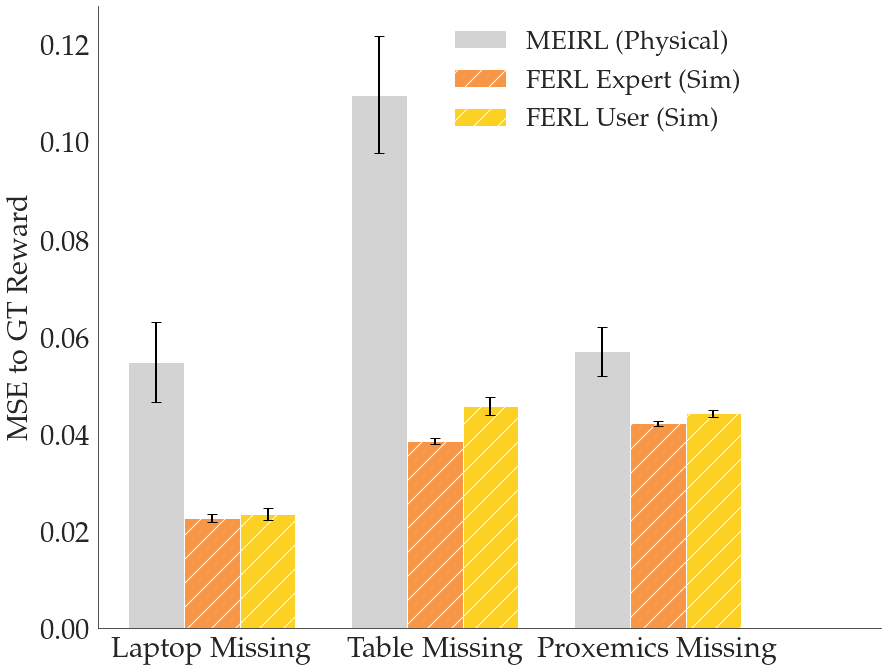

In [42]:
bar_plot(MEIRLMSEs, expert_MSEs_to_plot, user_MSEs_to_plot)

In [32]:
# Hashes for Sim and otherwise not
# MEIRL grey, user different orange
# try around if paltino

In [41]:
def bar_plot(GT, MEIRL, FERL):
    # Plot the pstar
    fontsize = 29
    fig = plt.figure(figsize=(13,10))
    matplotlib.rcParams.update({'font.size': fontsize})
    plt.rcParams['xtick.labelsize']=fontsize
    plt.rcParams['ytick.labelsize']=fontsize
    
#     set_style()
    FERL_color = '#fcd123'  # User
    MEIRL_color = '#f79646' # Expert
    GT_color = '#D3D3D3' # MEIRL #'#6283F7'
    labels = ["MEIRL (Physical)", "FERL Expert (Sim)", "FERL User (Sim)"]

    # set width of bar
    barWidth = 0.25

    for i in range(len(GT)):
        # Process input costs.
        gt_rel = np.array(GT[i])
        learned_rel = np.array(MEIRL[i]) 
        our_rel = np.array(FERL[i])

        # set height of bar
        bars1_mean = np.mean(gt_rel)
        bars1_sem = np.std(gt_rel) / np.sqrt(len(GT[i]))
        bars2_mean = np.mean(learned_rel)
        bars2_sem = np.std(learned_rel) / np.sqrt(len(MEIRL[i]))
        bars3_mean = np.mean(our_rel)
        bars3_sem = np.std(our_rel) / np.sqrt(len(FERL[i]))
    
        # Set position of bar on X axis
        r1 = np.arange(i, i+1)
        r2 = [x + barWidth for x in r1]
        r3 = [x + 2*barWidth for x in r1]

        # Make the plot
        if i > 0:
            labels = [None]*len(GT)
        plt.bar(r1, bars1_mean, yerr=bars1_sem, color=GT_color, width=barWidth,
                ecolor='black', error_kw=dict(elinewidth=2, capsize=5), label=labels[0])
        plt.bar(r2, bars2_mean, yerr=bars2_sem, color=MEIRL_color, width=barWidth,
                ecolor='black', error_kw=dict(elinewidth=2, capsize=5), label=labels[1], hatch='/')
        plt.bar(r3, bars3_mean, yerr=bars3_sem, color=FERL_color, width=barWidth,
                ecolor='black', error_kw=dict(elinewidth=2, capsize=5), label=labels[2], hatch='/')
    #axs.plot([0,n_max],[1, 1],color=random_color, linestyle='dashed', linewidth=6)
    # Add xticks on the middle of the group bars
    #plt.xlabel('Experimental Case', fontsize=fontsize)
    plt.ylabel('MSE to GT Reward', fontsize=fontsize)
    #plt.title("Induced Reward Relative to Ground Truth", fontsize=fontsize)
    plt.setp(plt.xticks()[1], fontsize=fontsize)
    plt.setp(plt.yticks()[1], fontsize=fontsize)
    plt.xticks(np.arange(4)+barWidth, ["Laptop Missing", "Table Missing", "Proxemics Missing"])
    
    # Create legend & Show graphic
    plt.legend(fontsize=26, frameon=False,loc=1,bbox_to_anchor=(0.85, 1.0))#, mode="expand", ncol=3)
    sns.despine(fig)
    plt.tight_layout()
    plt.savefig(parent_dir + '/data/images/UserStudy_Cost_MSE.pdf')
    plt.show()